In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SPADE LDM

In [2]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import zipfile
import gdown
from monai.data import DataLoader
from tqdm import tqdm
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import MultiScalePatchDiscriminator
import numpy as np
import monai
import torch.nn.functional as F
from generative.networks.nets.autoencoderkl import AutoencoderKL
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.networks.nets import PatchDiscriminator
from torch.cuda.amp import GradScaler, autocast
from generative.networks.schedulers import DDPMScheduler
from generative.inferers import LatentDiffusionInferer

In [3]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 6
num_workers = 4

### Data

The data for this notebook comes from the public dataset OASIS (Open Access Series of Imaging Studies) [1]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [2] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. In addition, BaMos [3] has been used to provide white matter hyperintensities segmentations (WMH). The available dataset contains:
- T1-weighted images
- FLAIR weighted images
- Segmentations with the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem) and 6 (WMH).

_**Acknowledgments**: "Data were provided by OASIS-3: Longitudinal Multimodal Neuroimaging: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P30 AG066444, P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.”_


Citations:

[1] Marcus, DS, Wang, TH, Parker, J, Csernansky, JG, Morris, JC, Buckner. Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults, RL. Journal of Cognitive Neuroscience, 19, 1498-1507. doi: 10.1162/jocn.2007.19.9.1498

[2] Cardoso MJ, Modat M, Wolz R, Melbourne A, Cash D, Rueckert D, Ourselin S. Geodesic Information Flows: Spatially-Variant Graphs and Their Application to Segmentation and Fusion. IEEE Trans Med Imaging. 2015 Sep;34(9):1976-88. doi: 10.1109/TMI.2015.2418298. Epub 2015 Apr 14. PMID: 25879909.

[3] Fiford CM, Sudre CH, Pemberton H, Walsh P, Manning E, Malone IB, Nicholas J, Bouvy WH, Carmichael OT, Biessels GJ, Cardoso MJ, Barnes J; Alzheimer’s Disease Neuroimaging Initiative. Automated White Matter Hyperintensity Segmentation Using Bayesian Model Selection: Assessment and Correlations with Cognitive Change. Neuroinformatics. 2020 Jun;18(3):429-449. doi: 10.1007/s12021-019-09439-6. PMID: 32062817; PMCID: PMC7338814.


In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " % root_dir)

Temporary directory used: /tmp/tmp96bb_zf3 


In [5]:
gdown.download(
    "https://drive.google.com/uc?export=download&id=1SX_MCzQe-vyq09QYxECk32wZ2vxp9rx5", str(root_dir / "data.zip")
)

Downloading...
From: https://drive.google.com/uc?export=download&id=1SX_MCzQe-vyq09QYxECk32wZ2vxp9rx5
To: /tmp/tmp96bb_zf3/data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384M/384M [00:06<00:00, 60.2MB/s]


'/tmp/tmp96bb_zf3/data.zip'

In [48]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, "data.zip"), "r")
zip_obj.extractall(root_dir)
images_T1 = root_dir / "OASIS_SMALL-SUBSET/T1"
images_FLAIR = root_dir / "OASIS_SMALL-SUBSET/FLAIR"
labels = root_dir / "OASIS_SMALL-SUBSET/Segmentations"

In [49]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_T1, i) for i in os.listdir(images_T1)]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

### Dataloaders

In [50]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=["image", "label"], spatial_size=input_shape),
]
last_transforms = [
    monai.transforms.CopyItemsd(keys=["label"], names=["label_channel"]),
    monai.transforms.Lambdad(keys=["label_channel"], func=lambda l: l != 0),
    monai.transforms.MaskIntensityd(keys=["image"], mask_key="label_channel"),
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

torch.Size([6, 1, 128, 128])


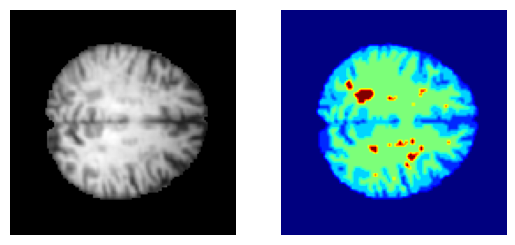

In [51]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Networks creation and losses

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [56]:
def picture_results(input_label, input_image, output_image):
    f = plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

SPADE Diffusion Models require two components:
- Autoencoder, incorporating SPADE normalisation in the decoder blocks
- Diffusion model, operating in the latent space, and incorporating SPADE normalisation in the decoding branch

In [57]:
autoencoder = AutoencoderKL(spatial_dims = 2, in_channels = 1, out_channels = 1, 
                           num_res_blocks = (2,2,2,2), num_channels = (8, 16, 32, 64),
                           attention_levels = [False, False, False, False],
                           latent_channels = 8, spade_norm = True, norm_num_groups = 8,
                           label_nc = 6
                           )

In [58]:
diffusion = DiffusionModelUNet(spatial_dims = 2, in_channels = 8, out_channels = 8,
                              num_res_blocks = (2,2,2,2), num_channels = (16, 32, 64, 128),
                              attention_levels = (False, False, True, True), norm_num_groups = 16,
                              with_conditioning = False, spade_norm = True, label_nc = 6)

To train the autoencoder, we are using **a Patch-GAN-based adversarial loss**, a **perceptual loss** and a basic **L1 loss** between input and output. 

In [59]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

PerceptualLoss(
  (perceptual_function): LPIPS(
    (scaling_layer): ScalingLayer()
    (net): alexnet(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        (1): ReLU(inplace=True)
      )
      (slice2): Sequential(
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (4): ReLU(inplace=True)
      )
      (slice3): Sequential(
        (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
      )
      (slice4): Sequential(
        (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
      )
      (slice5): Sequential(
        (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): Re

In [60]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=16, in_channels=1, out_channels=1,
                                  )
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [61]:
recon = torch.nn.L1Loss()

In [62]:
optimizer_G = torch.optim.Adam(autoencoder.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0004)
# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

### Training the autoencoder

We used the exact same approach as the one from the 2d_ldm_tutorial to train the autoencoder.

In [63]:
## Loss weights and number of epochs
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
adv_weights = 0.01
autoencoder_warm_up_n_epochs = 10
perceptual_weight = 0.001

Epoch 9: 100%|█████████████████████| 8/8 [00:01<00:00,  5.83it/s, recons_loss=0.0857, gen_loss=0, disc_loss=0]


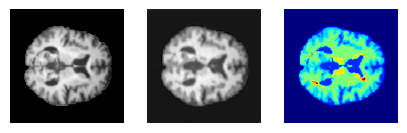

epoch 10 val loss: 0.0745


Epoch 19: 100%|████████████| 8/8 [00:01<00:00,  5.51it/s, recons_loss=0.0709, gen_loss=0.258, disc_loss=0.254]


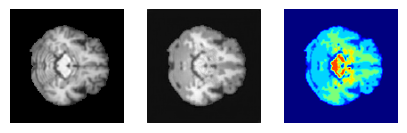

epoch 20 val loss: 0.0633


Epoch 29: 100%|█████████████| 8/8 [00:01<00:00,  5.44it/s, recons_loss=0.0637, gen_loss=0.26, disc_loss=0.252]


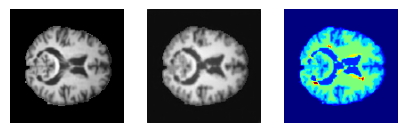

epoch 30 val loss: 0.0639


Epoch 39: 100%|█████████████| 8/8 [00:01<00:00,  5.54it/s, recons_loss=0.0605, gen_loss=0.25, disc_loss=0.251]


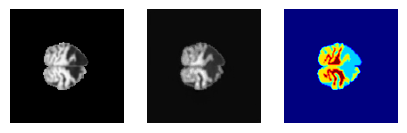

epoch 40 val loss: 0.0533


Epoch 49: 100%|████████████| 8/8 [00:01<00:00,  5.51it/s, recons_loss=0.0614, gen_loss=0.249, disc_loss=0.251]


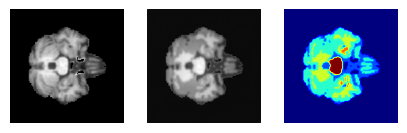

epoch 50 val loss: 0.0609


Epoch 59: 100%|█████████████| 8/8 [00:01<00:00,  5.42it/s, recons_loss=0.0606, gen_loss=0.254, disc_loss=0.25]


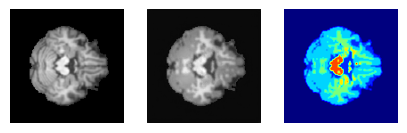

epoch 60 val loss: 0.0553


Epoch 69: 100%|██████████████| 8/8 [00:01<00:00,  5.49it/s, recons_loss=0.057, gen_loss=0.258, disc_loss=0.25]


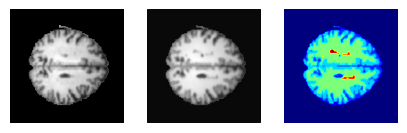

epoch 70 val loss: 0.0517


Epoch 79: 100%|████████████| 8/8 [00:01<00:00,  5.48it/s, recons_loss=0.0553, gen_loss=0.274, disc_loss=0.247]


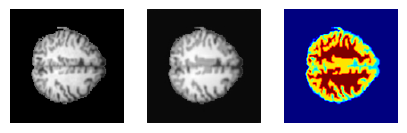

epoch 80 val loss: 0.0498


Epoch 89: 100%|████████████| 8/8 [00:01<00:00,  5.46it/s, recons_loss=0.0571, gen_loss=0.274, disc_loss=0.252]


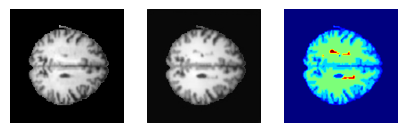

epoch 90 val loss: 0.0514


Epoch 99: 100%|████████████| 8/8 [00:01<00:00,  5.47it/s, recons_loss=0.0526, gen_loss=0.278, disc_loss=0.232]


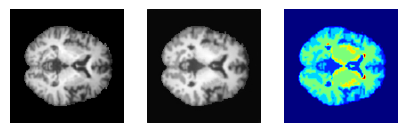

epoch 100 val loss: 0.0488


In [64]:
autoencoder.to(device)

# Loss storage
epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        labels = one_hot(batch['label'], 6).to(device)
        optimizer_G.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoder(images, labels)
            recons_loss = recon(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_G)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_D.zero_grad(set_to_none=True)
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_D)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
        
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoder.eval()
        val_loss = 0     
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=0):
                images = batch["image"].to(device)
                labels = one_hot(batch['label'], 6).to(device)
                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoder(images, labels)
                    recons_loss = recon(images.float(), reconstruction.float())
                val_loss += recons_loss.item()
                # We retrieve the image to plot
                if val_step == 0:
                    reconstruction = reconstruction.detach().cpu()
                    plt.figure(figsize=(5,3))
                    plt.subplot(1, 3, 1)
                    plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
                    plt.axis("off")
                    plt.subplot(1, 3, 2)
                    plt.imshow(reconstruction[0, 0, ...], cmap = "gist_gray")
                    plt.axis('off')
                    plt.subplot(1, 3, 3)
                    plt.imshow(batch["label"][0, 0, ...].detach().cpu(), cmap="jet") 
                    plt.axis("off")
                    plt.show()
                    

        val_loss /= max(val_step, 1)
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
        
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

### Training the diffusion model

Likewise, we use the same approach as in the 2d_ldm_tutorial.

In [ ]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
inferer = LatentDiffusionInferer(scheduler, scale_factor=1.0, is_spade_ae = True)

Epoch 39: 100%|█████████████| 8/8 [00:01<00:00,  4.51it/s, loss=0.212]


Epoch 39 val loss: 0.5139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.35it/s]


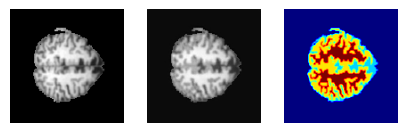

Epoch 79: 100%|█████████████| 8/8 [00:01<00:00,  4.47it/s, loss=0.272]


Epoch 79 val loss: 0.3017


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.94it/s]


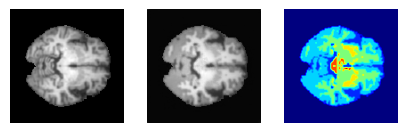

Epoch 119: 100%|████████████| 8/8 [00:01<00:00,  4.60it/s, loss=0.258]


Epoch 119 val loss: 0.1460


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.44it/s]


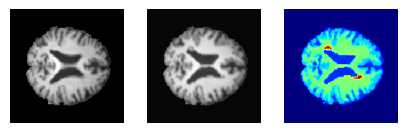

Epoch 159: 100%|█████████████| 8/8 [00:01<00:00,  4.42it/s, loss=0.31]


Epoch 159 val loss: 0.3419


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.82it/s]


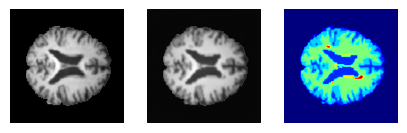

Epoch 199: 100%|████████████| 8/8 [00:01<00:00,  4.54it/s, loss=0.251]


Epoch 199 val loss: 0.1521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.28it/s]


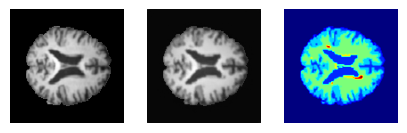

In [77]:
diffusion = diffusion.to(device)
n_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    diffusion.train()
    autoencoder.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        labels = one_hot(batch["label"], 6).to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoder.encode(images)
            z = autoencoder.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=diffusion, noise=noise, timesteps=timesteps, autoencoder_model=autoencoder,
                seg = labels
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        diffusion.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                labels = one_hot(batch["label"], 6).to(device)
                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoder.encode(images)

                    z = autoencoder.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=diffusion,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoder,
                        seg = labels, 
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training. We use the last segmentation of our loader
        z = torch.randn((labels.shape[0], 8, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=diffusion, scheduler=scheduler, autoencoder_model=autoencoder,
                seg = labels)    
        plt.figure(figsize=(5, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(decoded[0, 0, ...].detach().cpu(), cmap = "gist_gray")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(batch["label"][0, 0, ...].detach().cpu(), cmap="jet") 
        plt.axis("off")
        plt.show()

progress_bar.close()
